In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LeakyReLU 
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

In [2]:
from numpy.random import seed
seed(1)

# Data

In [3]:
# Number training data samples
N = 10000

data_1 = np.random.normal(5, 1.2, size=60000)
data_2 = np.random.normal(10, 1.5, size=40000)

data = shuffle(np.concatenate((data_1, data_2)))

In [4]:
bins = np.linspace(0, 15, num=16 )
bin_indices = np.digitize(data, bins) - 1

In [5]:
data_temp = ((np.arange(16) == bin_indices[:,None]).astype(int))

(array([1.0000e+00, 3.2000e+01, 3.3300e+02, 2.4650e+03, 9.2570e+03,
        1.7766e+04, 1.8054e+04, 1.0092e+04, 5.1410e+03, 6.7850e+03,
        9.9900e+03, 1.0017e+04, 6.4350e+03, 2.7450e+03, 7.2000e+02,
        1.6700e+02]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15.]),
 <BarContainer object of 16 artists>)

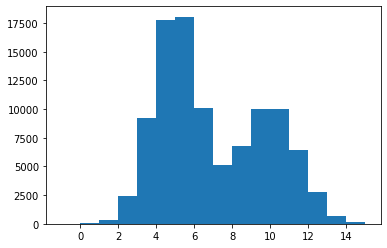

In [6]:
plt.hist(bin_indices, bins = 16)

In [7]:
data_process = []
for i in range(int(N)):
    idx = np.random.randint(N, size=1000)
    temp = data_temp[idx]
    new_point = np.sum(temp, axis = 0)/1000
    data_process.append(new_point)
data_processed = np.array(data_process)

In [8]:
BATCH_SIZE = 100
data_loader = DataLoader(data_processed, batch_size=BATCH_SIZE, shuffle=True)

# Networks

## Discriminator

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation=tf.nn.sigmoid))

    return model

## Generator

In [10]:
n_qubits = 4
# size = 100
q_depth = 3

In [11]:
dev = qml.device("default.qubit", wires= n_qubits)

In [12]:
@qml.qnode(dev, interface="tf")
def qnode(inputs, weights):
    #qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    #qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits),rotation= qml.RY)
    
    # Init distribution
    for a in range(n_qubits):
        qml.Hadamard(wires=a)
    
    # Actual distribution
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RX(weights[2*(i*n_qubits + j)], wires=j)
            qml.RY(weights[2*(i*n_qubits + j) + 1], wires=j)
            
        for k in range(n_qubits):
            if (k == (n_qubits - 1)):
                qml.CZ(wires=[k,0])
            else:
                qml.CZ(wires=[k,k+1])
    
    for l in range(n_qubits):
        qml.RX(weights[(2*q_depth * n_qubits) + l], wires=l)
        qml.RY(weights[(2*q_depth * n_qubits) + l + 1], wires=l)
    
    return qml.probs(wires=range(n_qubits))

In [13]:
weight_shapes = {"weights": (2 * (q_depth +1) * n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=16)

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(qlayer)

    return model

In [15]:
generator = make_generator_model()


In [16]:
discriminator = make_discriminator_model()

In [17]:
noise = tf.random.normal([100, 4])

In [18]:
generator(noise)

<tf.Tensor: shape=(100, 16), dtype=float64, numpy=
array([[0.074038  , 0.04376455, 0.12406058, ..., 0.02923218, 0.0589976 ,
        0.03077196],
       [0.074038  , 0.04376455, 0.12406058, ..., 0.02923218, 0.0589976 ,
        0.03077196],
       [0.074038  , 0.04376455, 0.12406058, ..., 0.02923218, 0.0589976 ,
        0.03077196],
       ...,
       [0.074038  , 0.04376455, 0.12406058, ..., 0.02923218, 0.0589976 ,
        0.03077196],
       [0.074038  , 0.04376455, 0.12406058, ..., 0.02923218, 0.0589976 ,
        0.03077196],
       [0.074038  , 0.04376455, 0.12406058, ..., 0.02923218, 0.0589976 ,
        0.03077196]])>

# Cost function

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
#generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)

# Training

In [23]:
EPOCHS = 150
noise_dim = n_qubits
num_examples_to_generate = 100
#BUFFER_SIZE = 60000


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        test_data = generator(seed, training=False).numpy()
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        y = range(16)
        ax.bar(y, test_data[0] )
        plt.show()
        
        for n_batch, batch in enumerate(dataset):
            X_batch = tf.convert_to_tensor(batch.numpy())
            train_step(X_batch)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,epochs, seed)

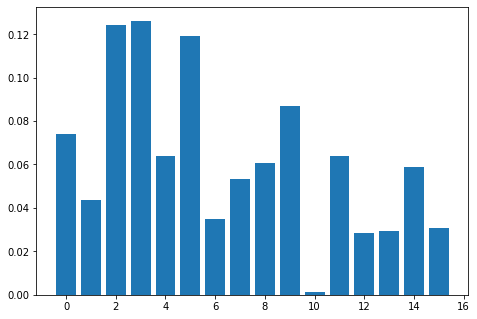

Time for epoch 1 is 721.2837581634521 sec


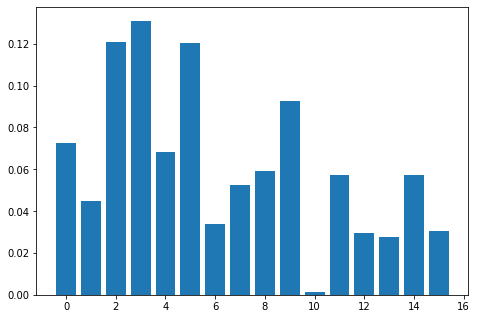

Time for epoch 2 is 10.431351900100708 sec


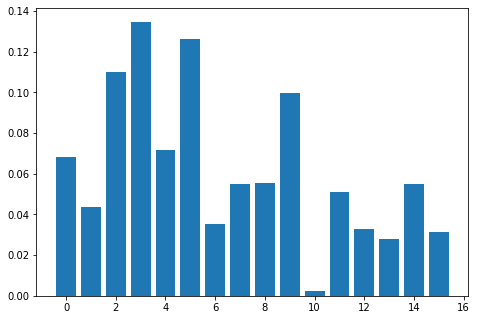

Time for epoch 3 is 9.725007772445679 sec


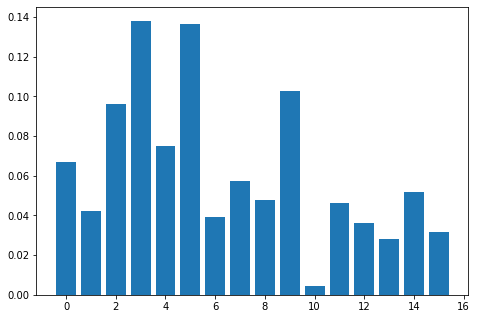

Time for epoch 4 is 9.751391649246216 sec


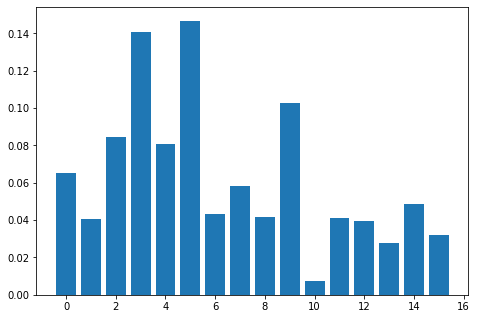

Time for epoch 5 is 9.77319073677063 sec


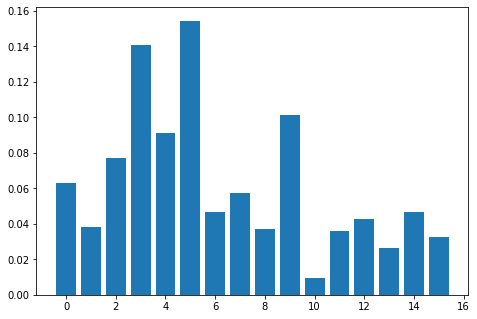

Time for epoch 6 is 9.774165868759155 sec


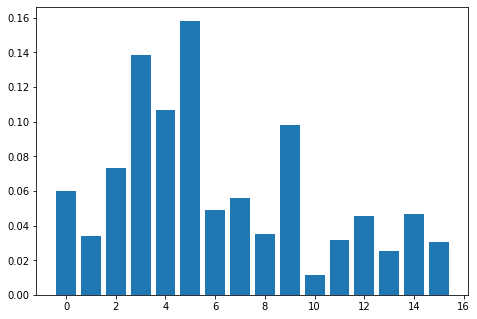

Time for epoch 7 is 9.79822039604187 sec


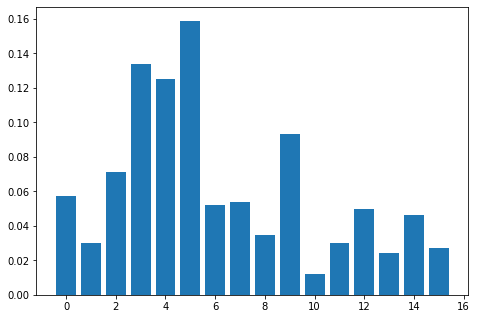

Time for epoch 8 is 10.732403755187988 sec


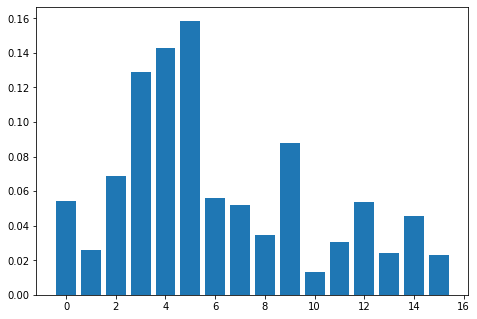

Time for epoch 9 is 15.33270001411438 sec


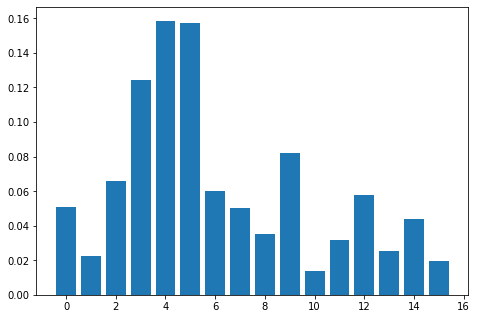

Time for epoch 10 is 13.928470611572266 sec


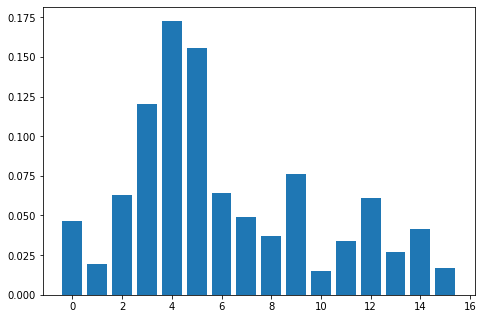

Time for epoch 11 is 11.554837226867676 sec


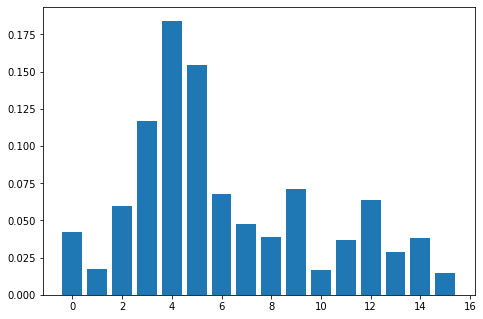

Time for epoch 12 is 9.867645978927612 sec


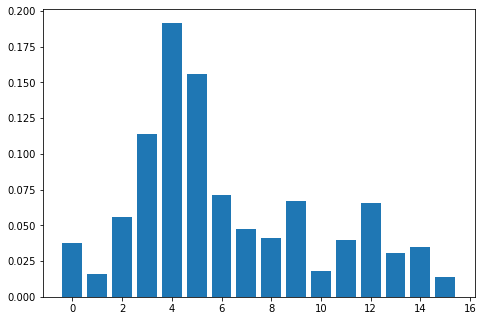

Time for epoch 13 is 11.413745880126953 sec


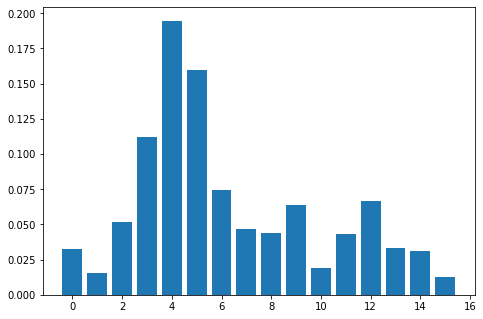

Time for epoch 14 is 11.384982109069824 sec


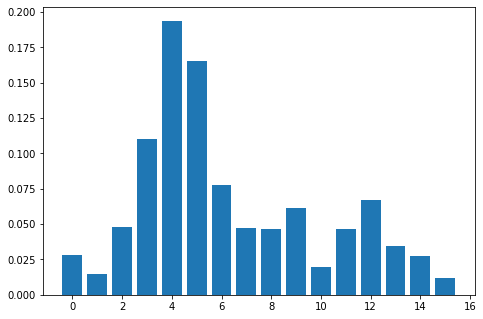

Time for epoch 15 is 10.093226671218872 sec


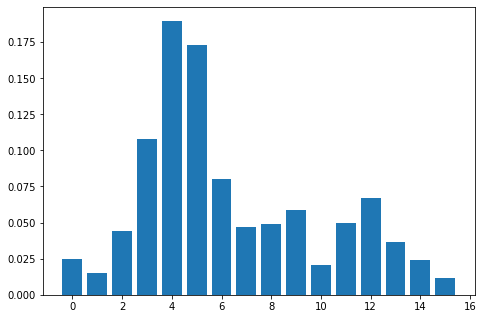

Time for epoch 16 is 10.266490697860718 sec


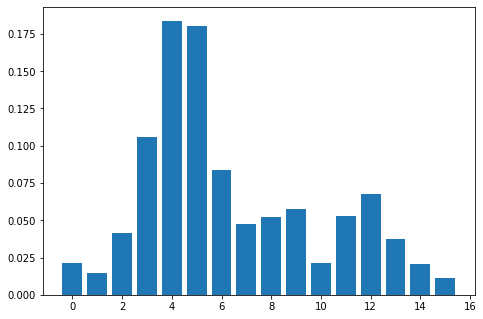

Time for epoch 17 is 13.987473011016846 sec


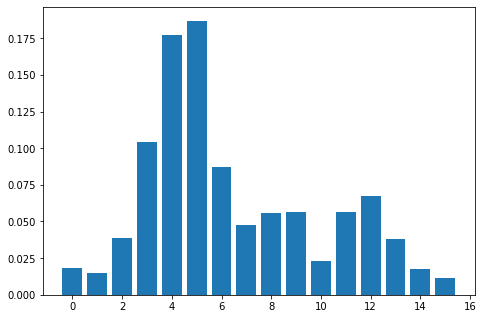

Time for epoch 18 is 13.200507640838623 sec


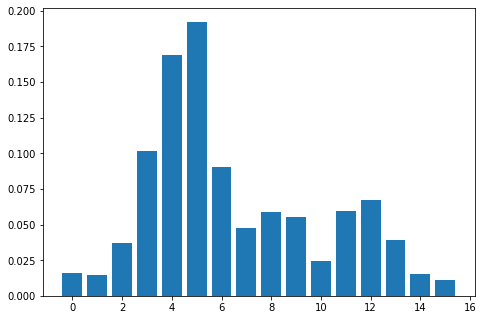

Time for epoch 19 is 9.938192367553711 sec


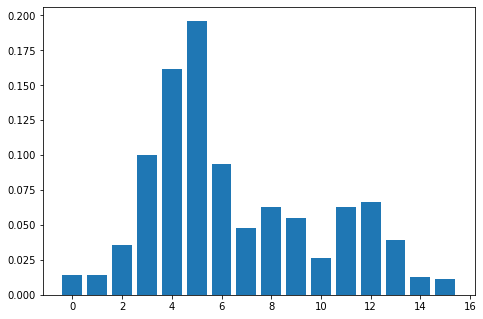

Time for epoch 20 is 12.835283517837524 sec


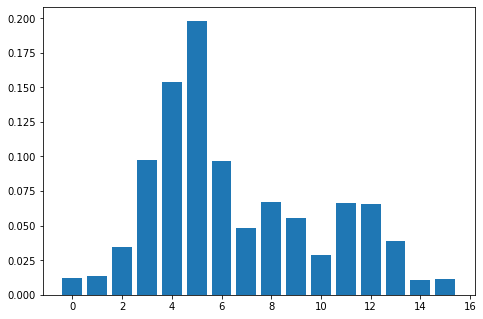

Time for epoch 21 is 11.988852977752686 sec


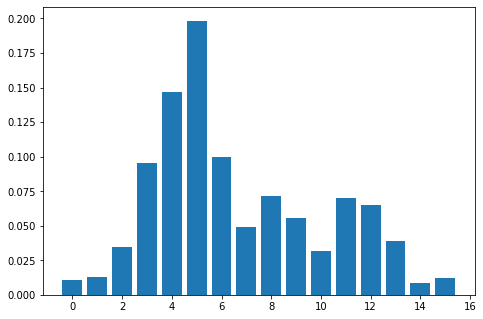

Time for epoch 22 is 10.919792175292969 sec


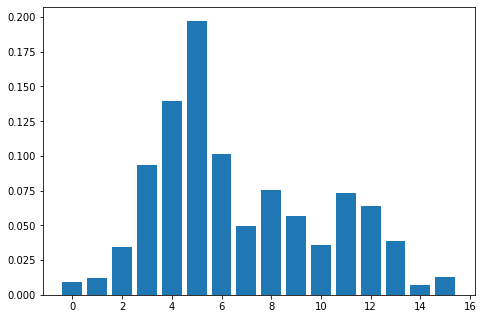

Time for epoch 23 is 9.803115844726562 sec


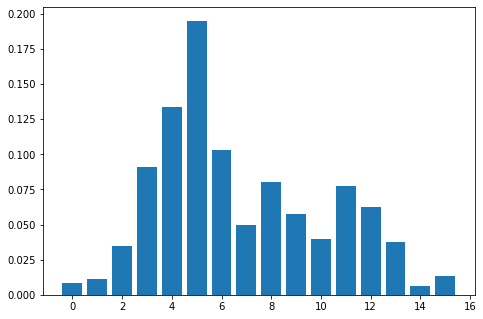

Time for epoch 24 is 9.068726539611816 sec


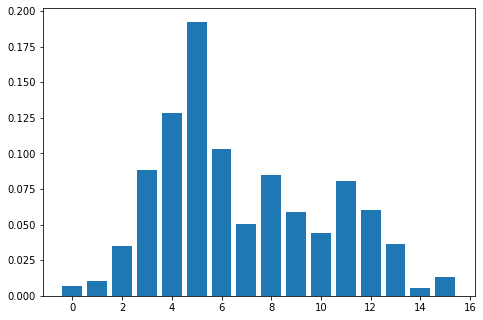

Time for epoch 25 is 9.181692838668823 sec


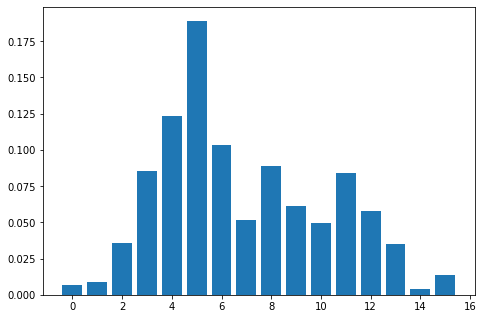

Time for epoch 26 is 9.35791540145874 sec


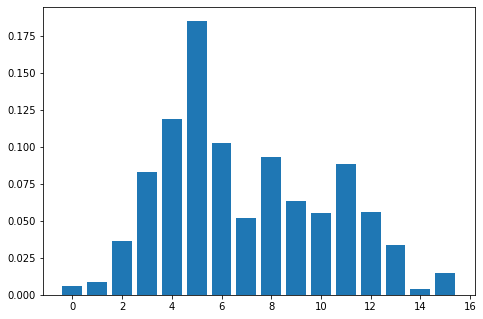

Time for epoch 27 is 9.193053483963013 sec


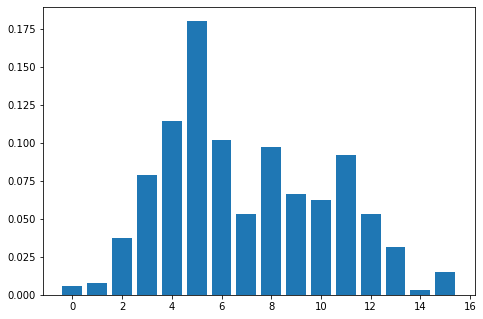

Time for epoch 28 is 9.09740400314331 sec


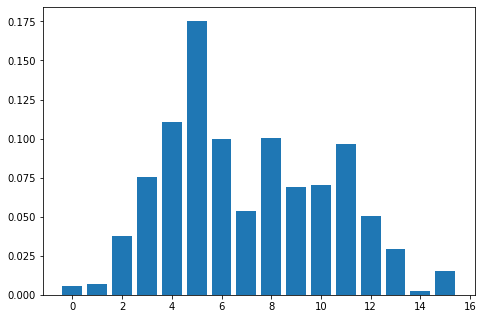

Time for epoch 29 is 8.928757190704346 sec


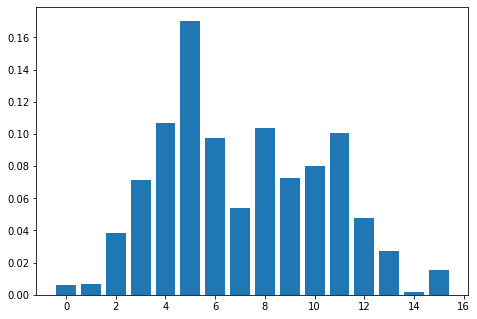

Time for epoch 30 is 8.942331075668335 sec


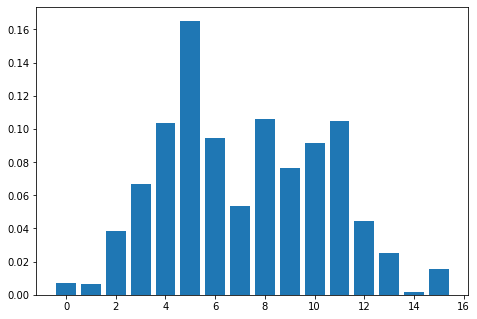

Time for epoch 31 is 8.969844341278076 sec


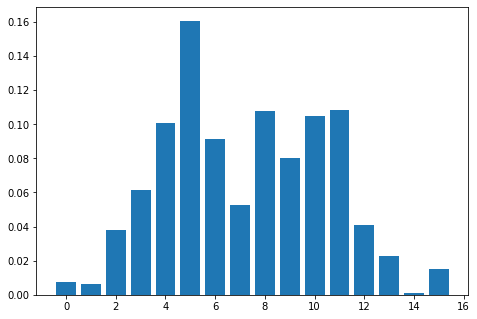

Time for epoch 32 is 9.291223764419556 sec


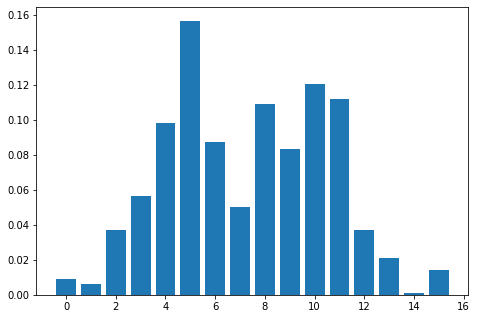

Time for epoch 33 is 9.369168043136597 sec


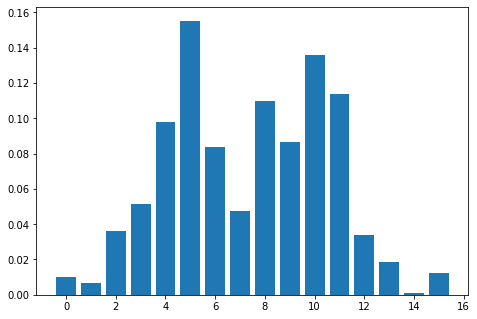

Time for epoch 34 is 9.529559850692749 sec


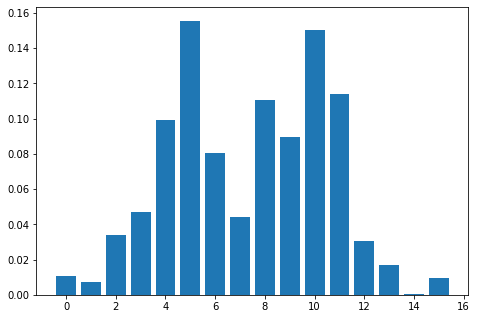

Time for epoch 35 is 11.028307437896729 sec


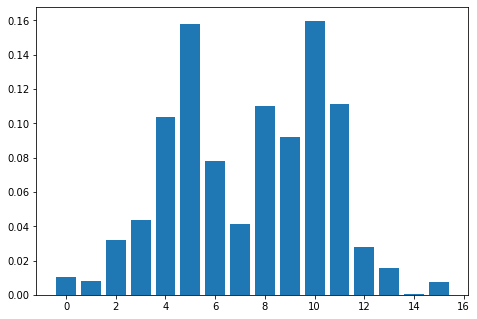

Time for epoch 36 is 11.187084197998047 sec


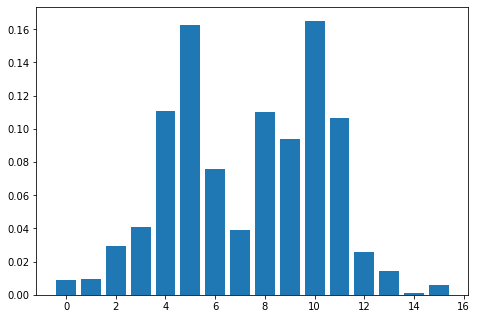

Time for epoch 37 is 11.104397058486938 sec


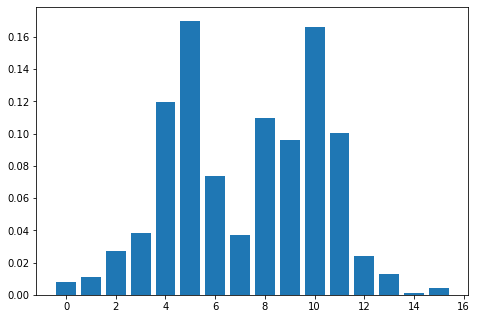

Time for epoch 38 is 11.591104507446289 sec


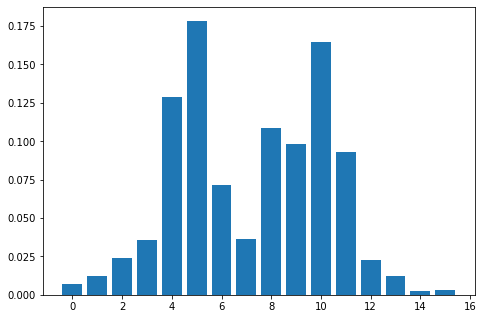

Time for epoch 39 is 10.325563192367554 sec


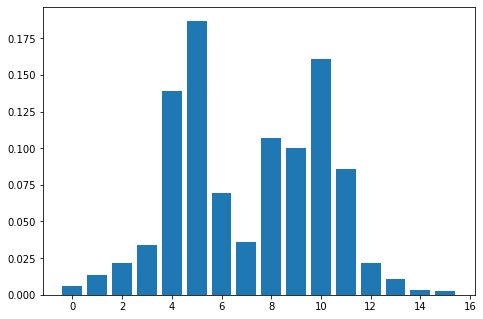

Time for epoch 40 is 10.38888955116272 sec


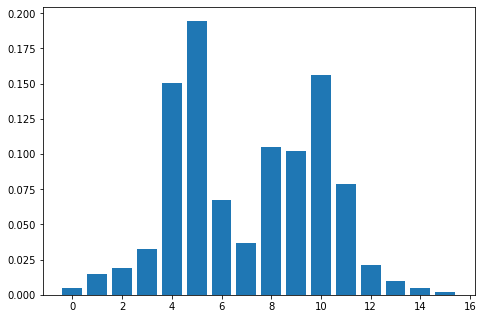

Time for epoch 41 is 10.834081649780273 sec


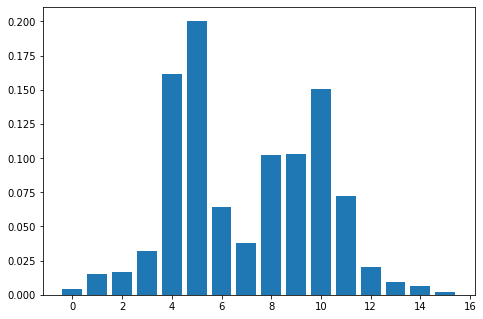

Time for epoch 42 is 9.764634132385254 sec


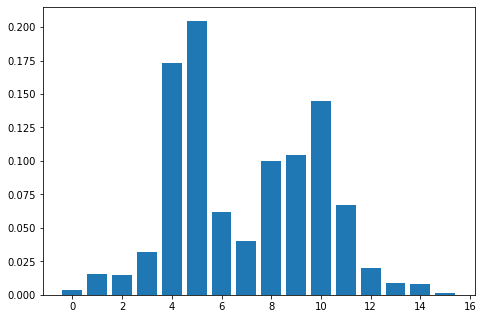

Time for epoch 43 is 9.487459897994995 sec


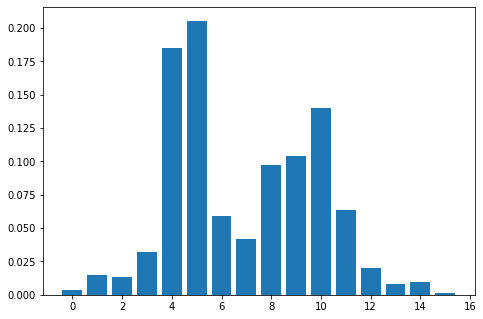

Time for epoch 44 is 8.97523045539856 sec


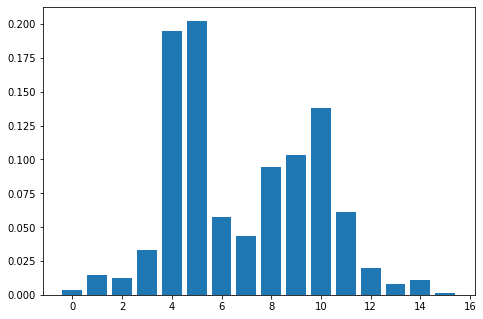

Time for epoch 45 is 9.017110347747803 sec


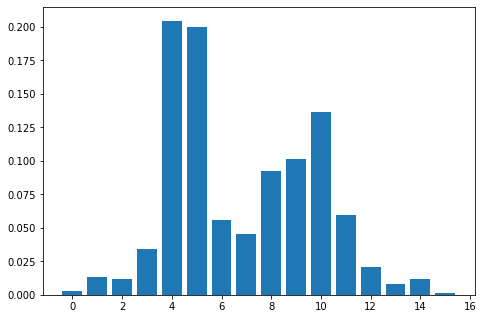

Time for epoch 46 is 9.709824800491333 sec


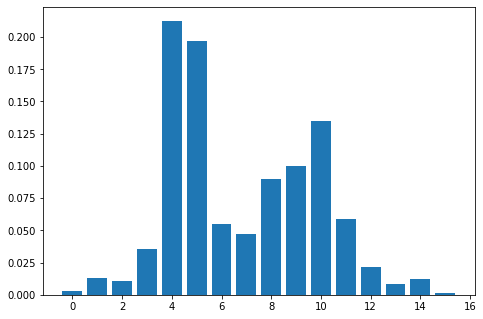

Time for epoch 47 is 9.668932676315308 sec


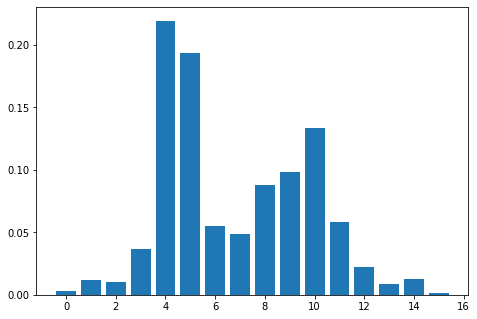

Time for epoch 48 is 9.673969745635986 sec


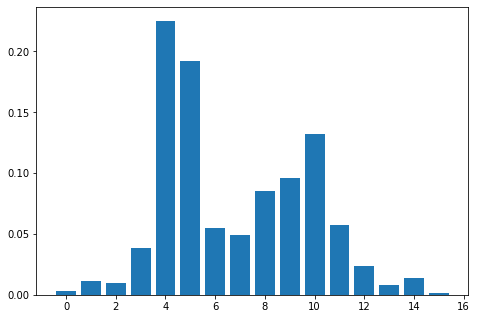

Time for epoch 49 is 10.152283191680908 sec


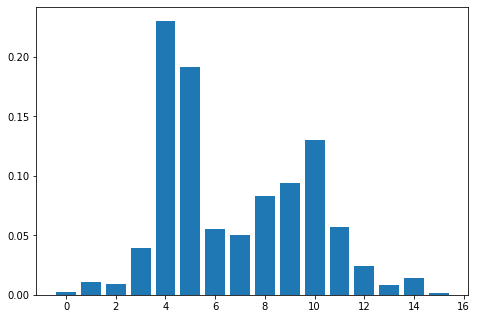

Time for epoch 50 is 10.026409149169922 sec


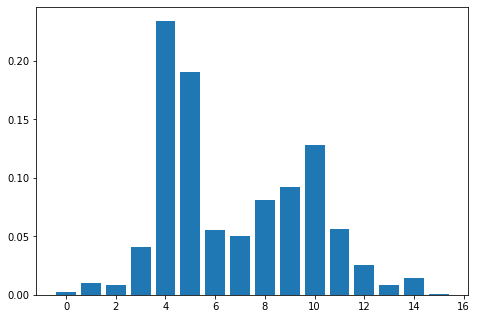

Time for epoch 51 is 11.344130516052246 sec


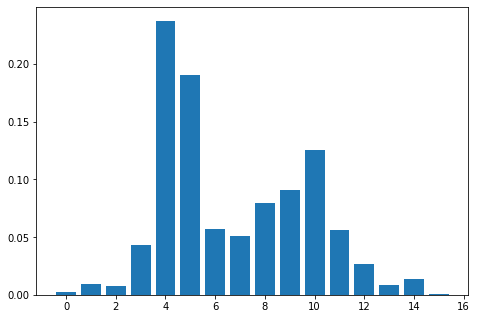

Time for epoch 52 is 12.182478427886963 sec


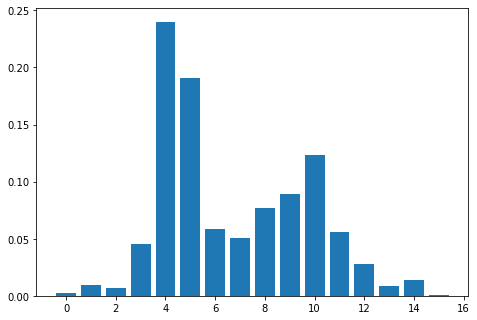

Time for epoch 53 is 10.75269889831543 sec


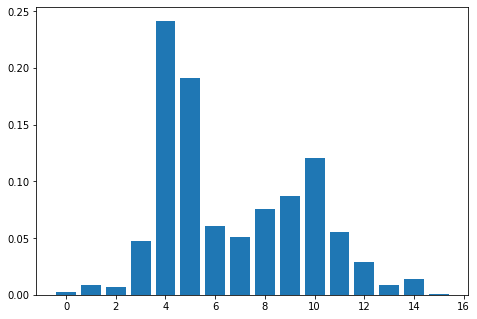

Time for epoch 54 is 10.821974515914917 sec


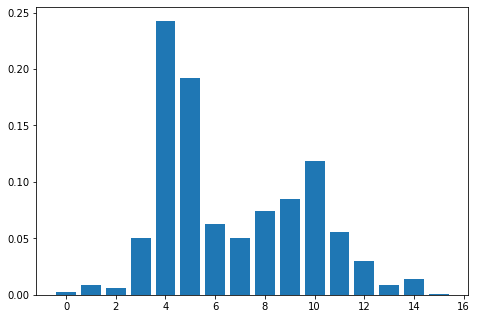

Time for epoch 55 is 10.518812894821167 sec


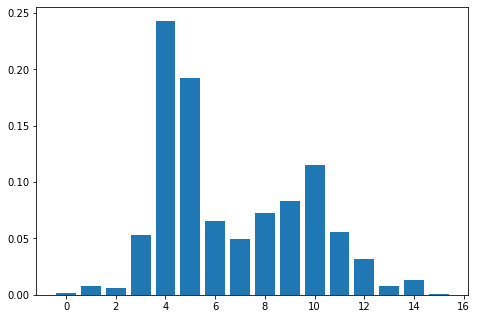

Time for epoch 56 is 10.362074375152588 sec


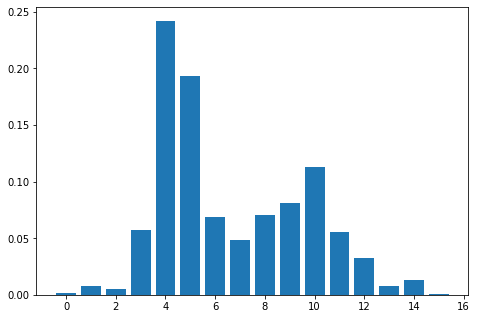

Time for epoch 57 is 10.111761093139648 sec


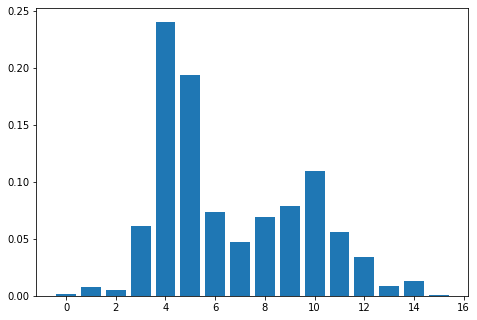

Time for epoch 58 is 10.101355075836182 sec


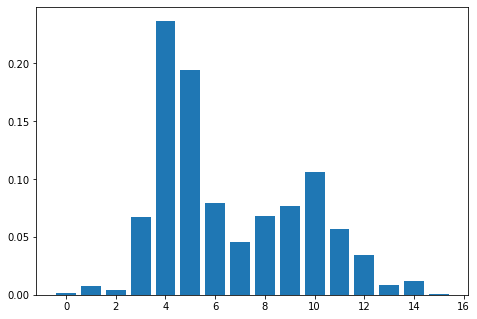

Time for epoch 59 is 9.943989753723145 sec


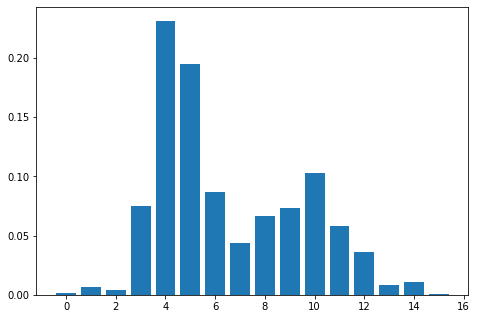

Time for epoch 60 is 9.754385471343994 sec


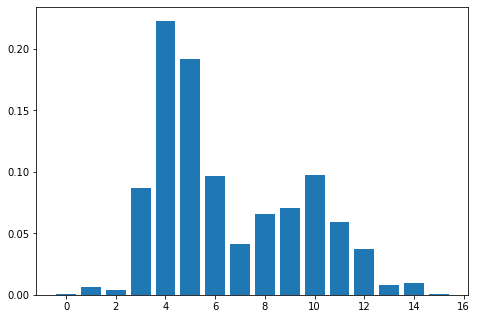

Time for epoch 61 is 9.770232439041138 sec


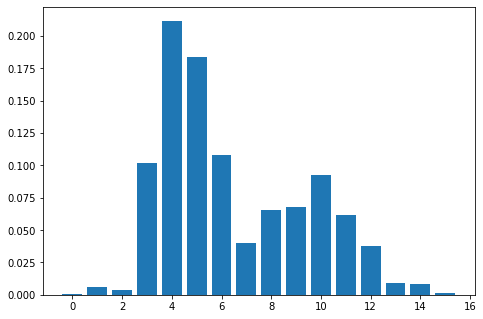

Time for epoch 62 is 9.603442668914795 sec


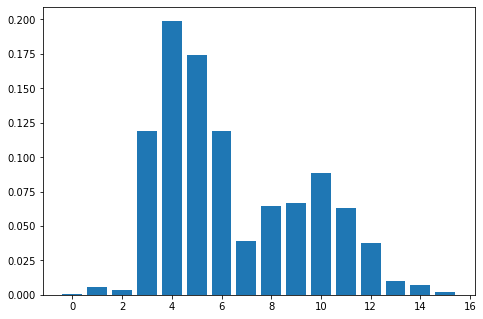

Time for epoch 63 is 9.430519580841064 sec


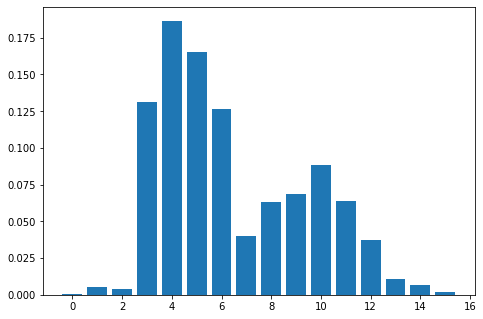

Time for epoch 64 is 9.150444984436035 sec


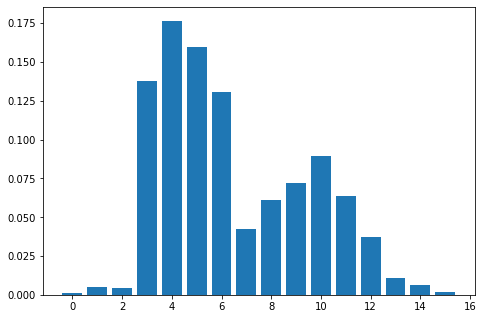

Time for epoch 65 is 9.422170400619507 sec


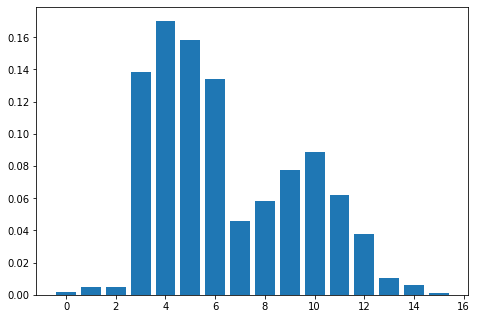

Time for epoch 66 is 9.640833377838135 sec


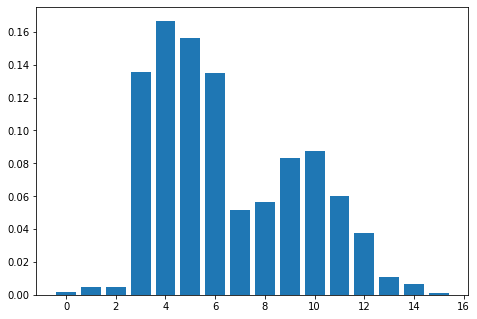

Time for epoch 67 is 9.63907766342163 sec


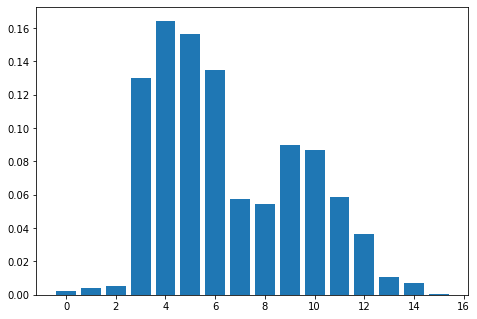

Time for epoch 68 is 9.649303913116455 sec


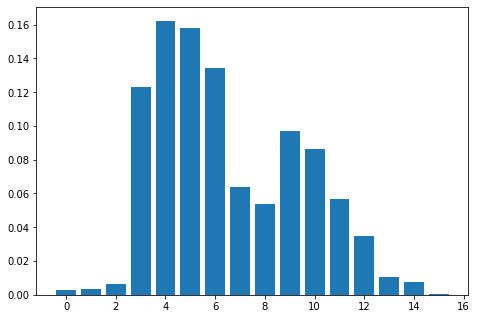

Time for epoch 69 is 9.442601442337036 sec


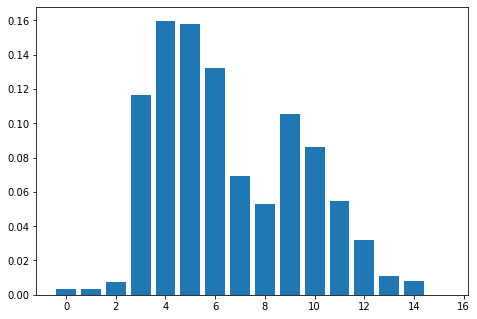

Time for epoch 70 is 9.15725827217102 sec


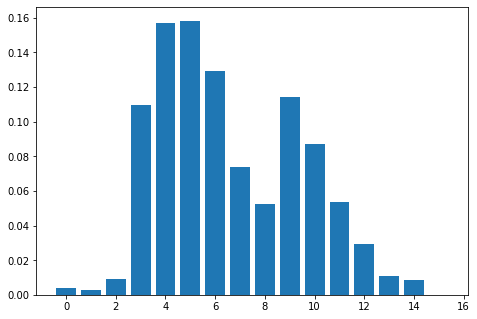

Time for epoch 71 is 9.118215799331665 sec


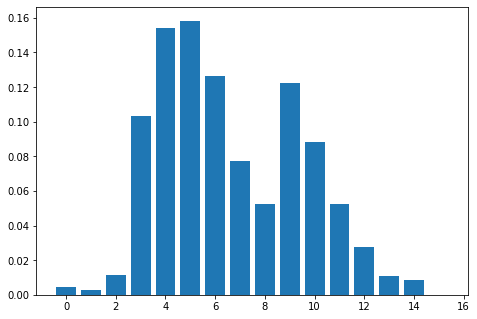

Time for epoch 72 is 9.506492614746094 sec


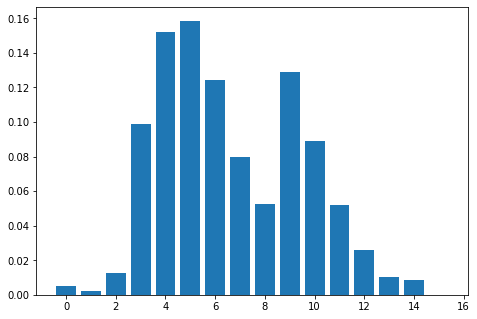

Time for epoch 73 is 9.079760789871216 sec


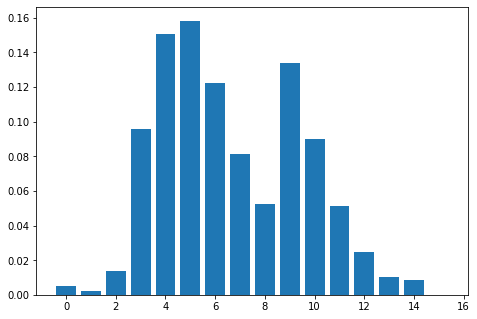

Time for epoch 74 is 9.344760656356812 sec


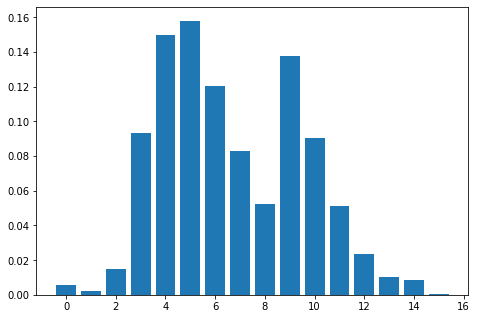

Time for epoch 75 is 9.022233486175537 sec


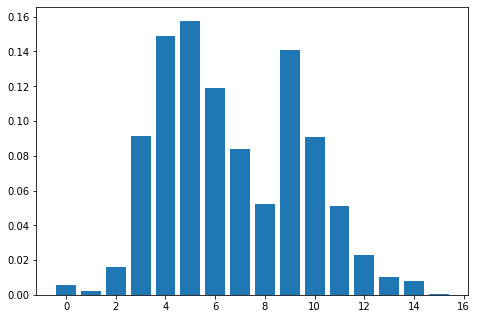

Time for epoch 76 is 8.774128913879395 sec


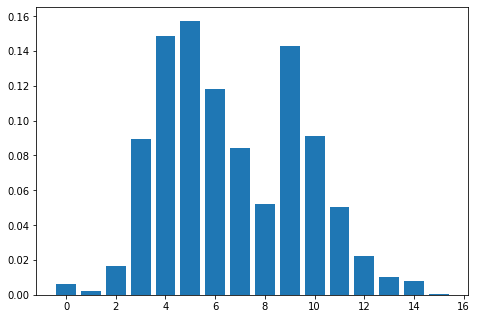

Time for epoch 77 is 8.80227255821228 sec


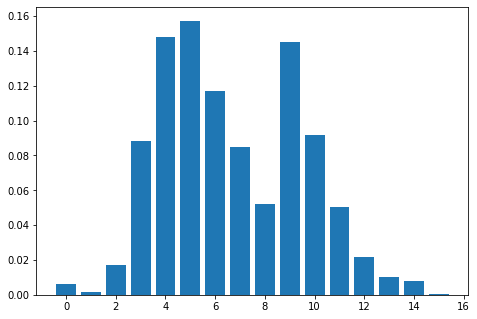

Time for epoch 78 is 9.143502473831177 sec


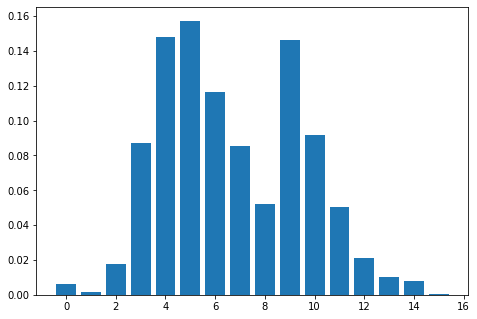

Time for epoch 79 is 9.087302923202515 sec


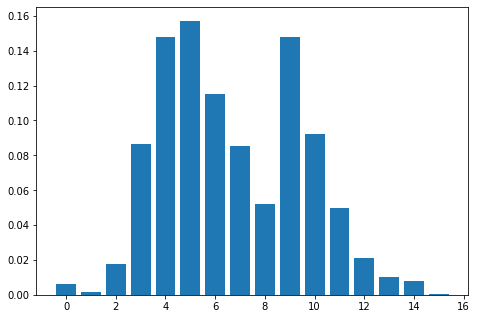

Time for epoch 80 is 8.96622085571289 sec


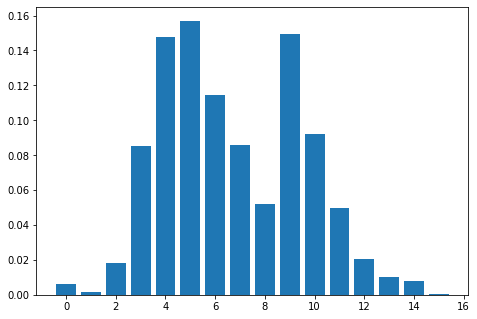

Time for epoch 81 is 8.61445665359497 sec


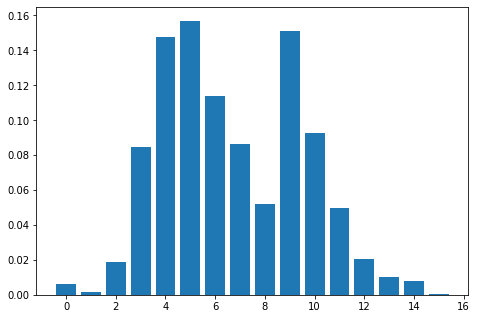

Time for epoch 82 is 8.904051065444946 sec


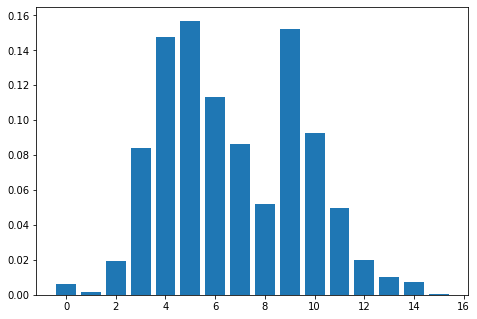

Time for epoch 83 is 9.156744718551636 sec


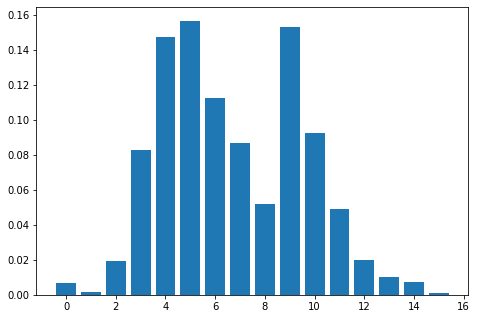

Time for epoch 84 is 8.728349447250366 sec


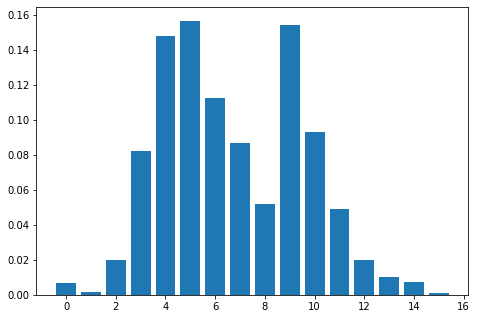

Time for epoch 85 is 8.816385984420776 sec


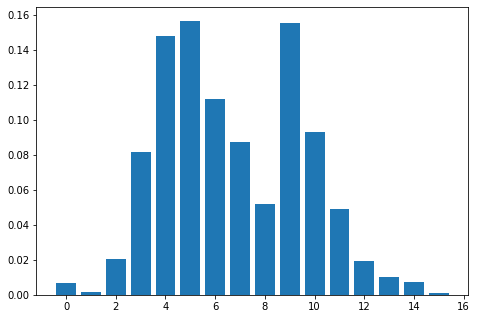

Time for epoch 86 is 8.801251649856567 sec


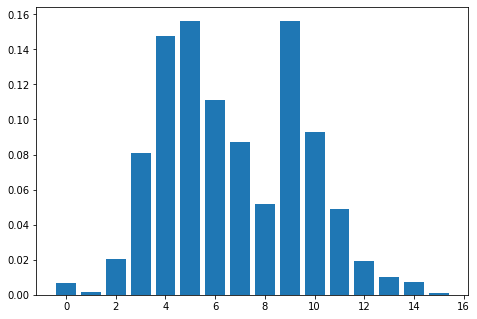

Time for epoch 87 is 8.980917692184448 sec


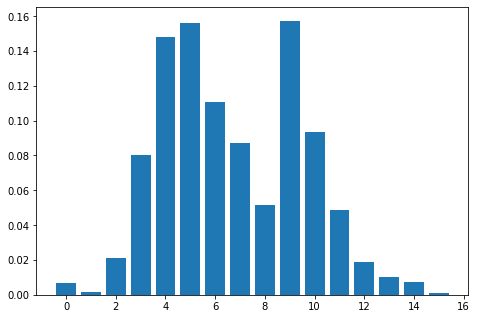

Time for epoch 88 is 8.736579418182373 sec


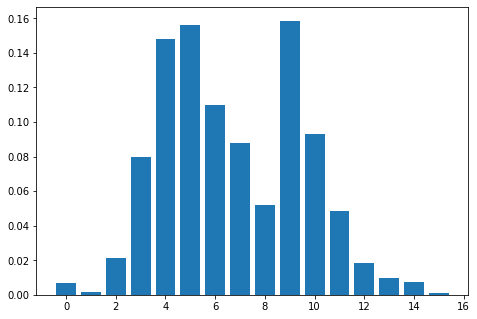

Time for epoch 89 is 8.697159051895142 sec


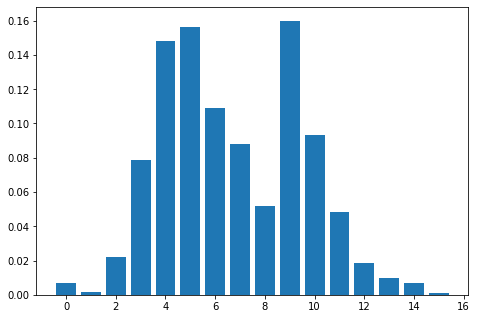

Time for epoch 90 is 8.759657621383667 sec


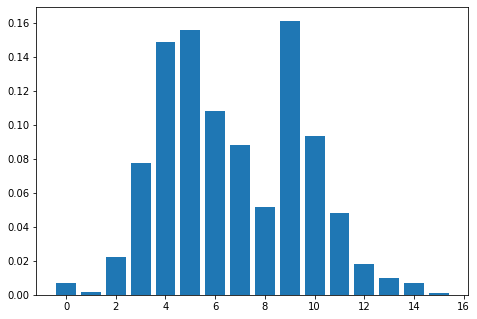

Time for epoch 91 is 9.137446165084839 sec


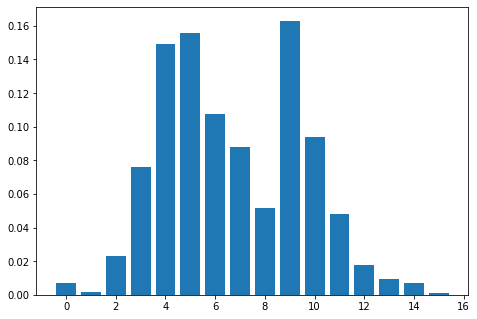

Time for epoch 92 is 9.087670087814331 sec


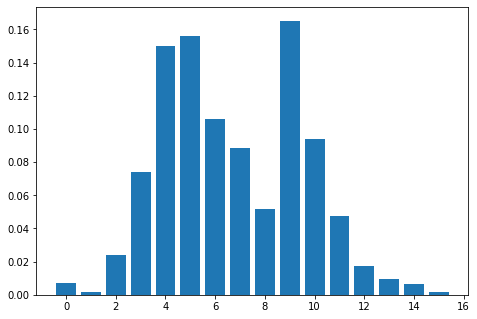

Time for epoch 93 is 10.252758502960205 sec


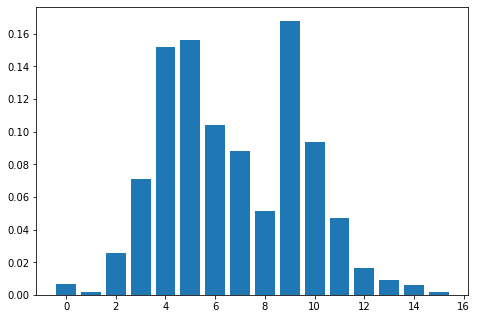

Time for epoch 94 is 10.903137445449829 sec


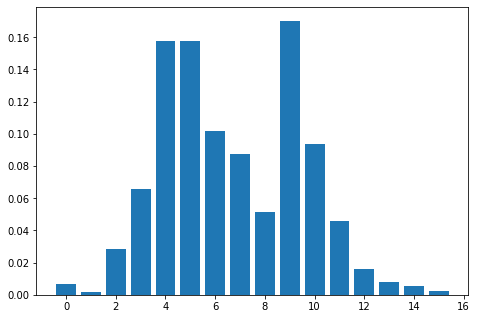

Time for epoch 95 is 10.543793201446533 sec


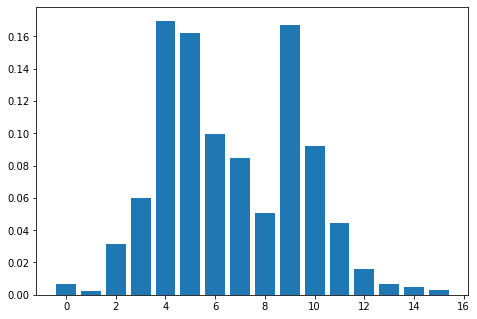

Time for epoch 96 is 10.34951376914978 sec


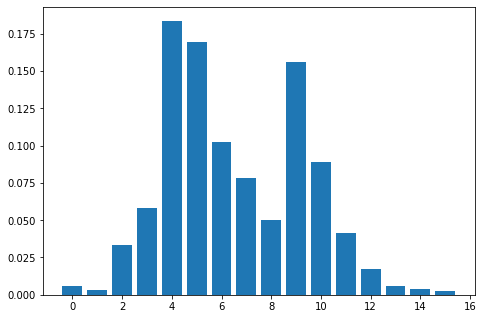

Time for epoch 97 is 10.139633655548096 sec


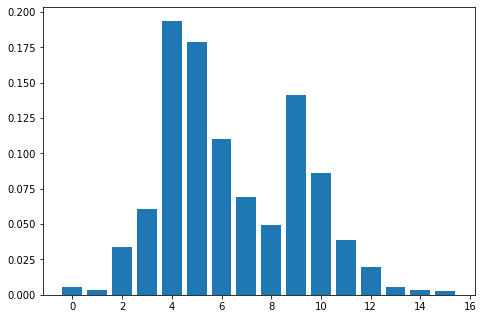

Time for epoch 98 is 10.020606994628906 sec


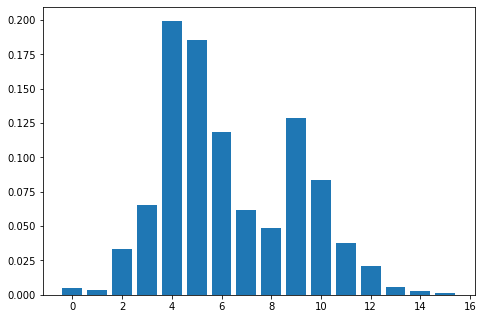

Time for epoch 99 is 9.872355222702026 sec


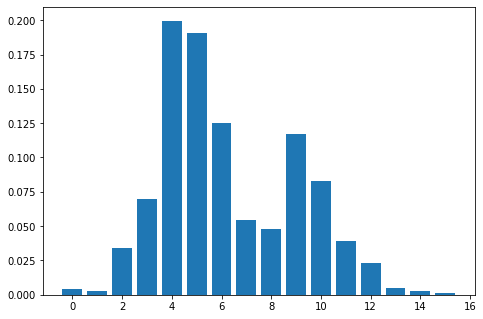

Time for epoch 100 is 9.800378322601318 sec


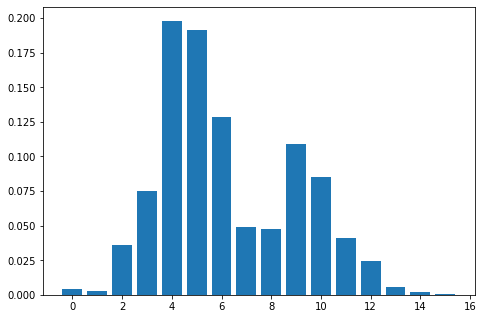

Time for epoch 101 is 9.824961423873901 sec


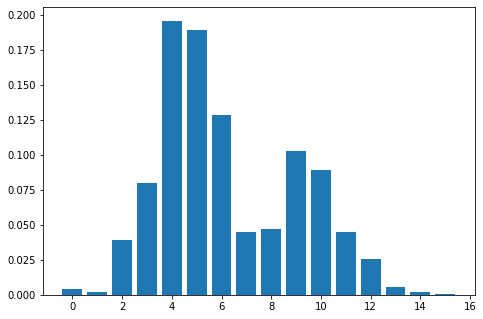

Time for epoch 102 is 9.830768346786499 sec


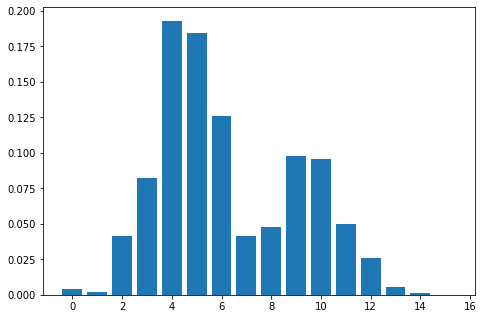

Time for epoch 103 is 9.638752698898315 sec


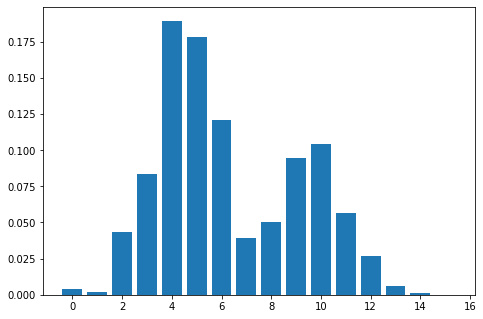

Time for epoch 104 is 9.452043771743774 sec


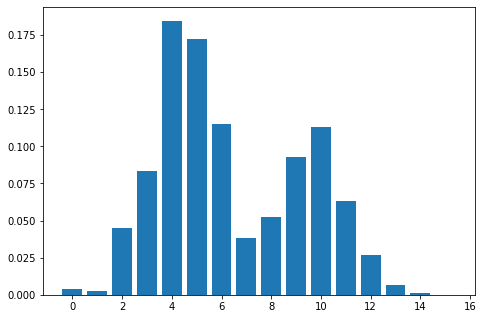

Time for epoch 105 is 9.540317296981812 sec


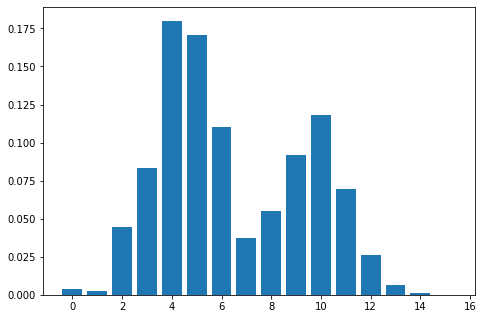

Time for epoch 106 is 9.595628023147583 sec


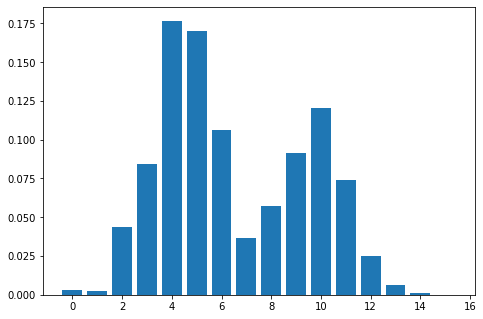

Time for epoch 107 is 9.425840854644775 sec


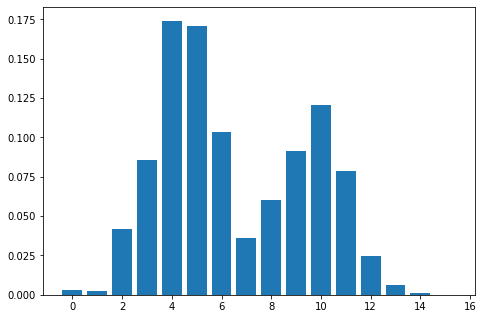

Time for epoch 108 is 9.488943576812744 sec


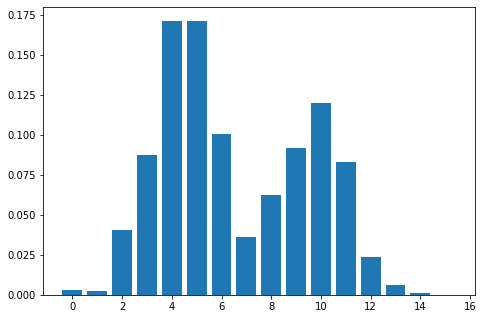

Time for epoch 109 is 9.630105257034302 sec


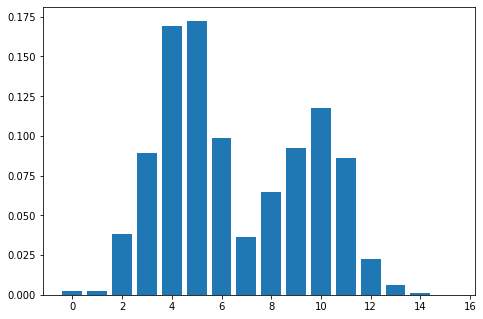

Time for epoch 110 is 9.672248125076294 sec


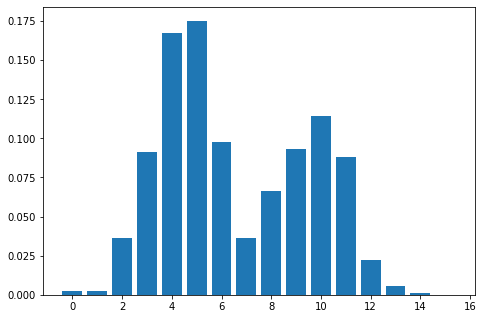

Time for epoch 111 is 9.649932384490967 sec


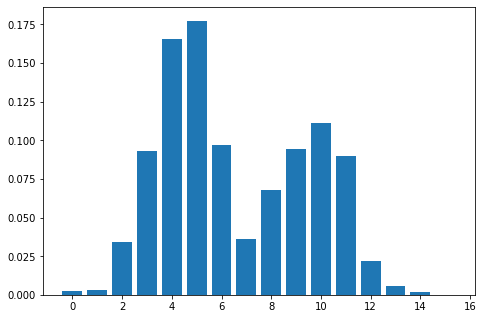

Time for epoch 112 is 9.42173433303833 sec


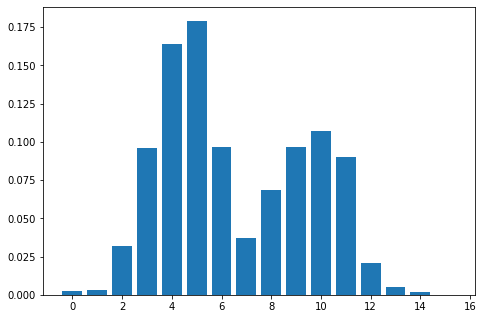

Time for epoch 113 is 9.36934518814087 sec


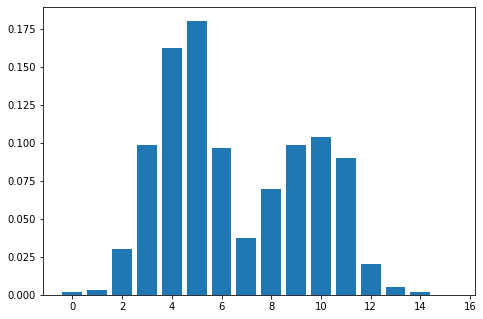

Time for epoch 114 is 9.440363645553589 sec


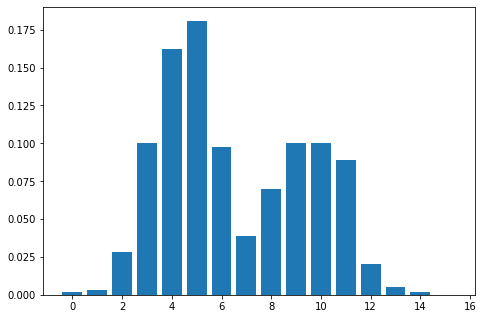

Time for epoch 115 is 9.48708200454712 sec


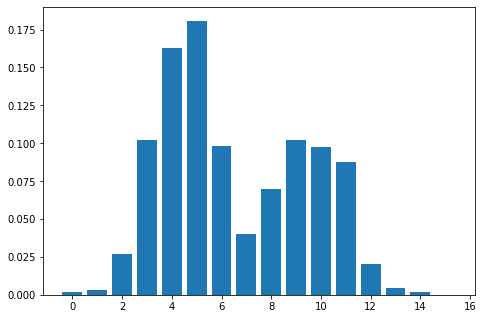

Time for epoch 116 is 9.695622682571411 sec


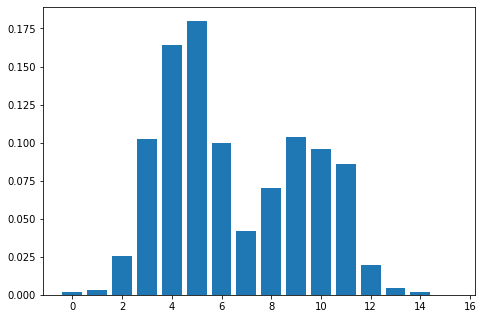

Time for epoch 117 is 9.676155805587769 sec


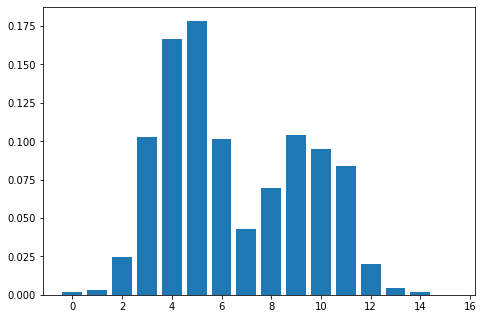

Time for epoch 118 is 9.699696779251099 sec


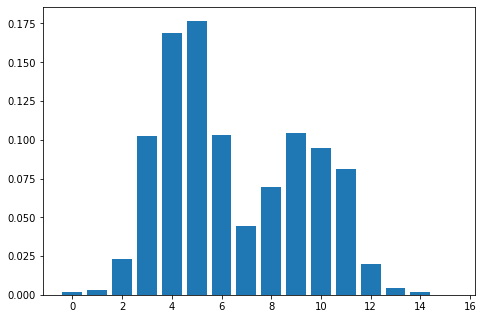

Time for epoch 119 is 9.76338815689087 sec


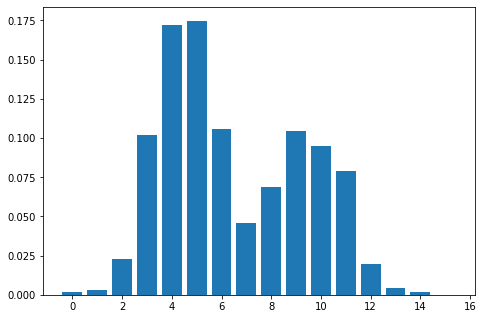

Time for epoch 120 is 9.48726511001587 sec


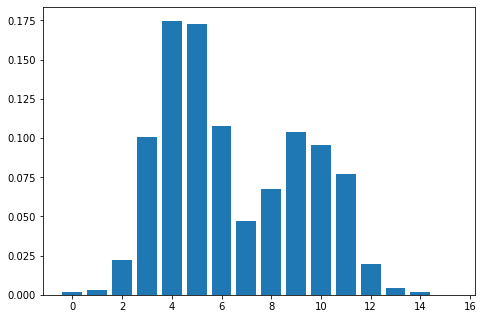

Time for epoch 121 is 9.562334775924683 sec


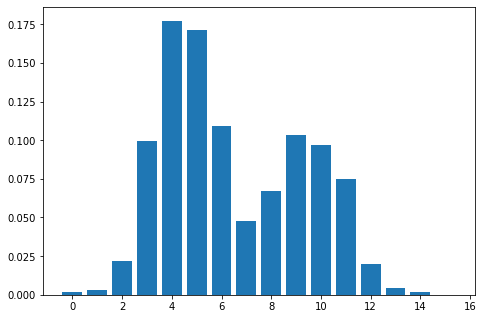

Time for epoch 122 is 9.448709964752197 sec


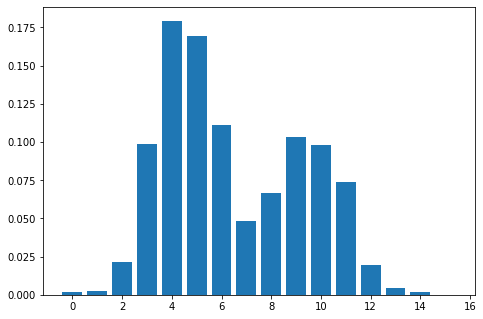

Time for epoch 123 is 9.163931846618652 sec


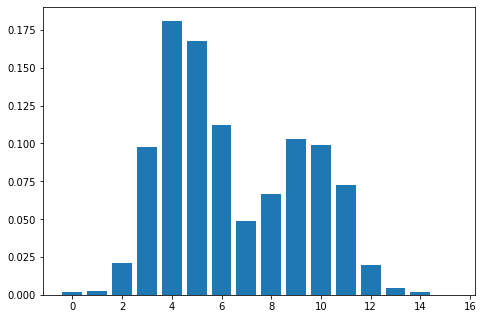

Time for epoch 124 is 9.334049701690674 sec


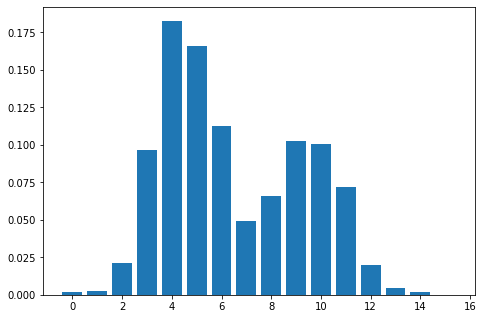

Time for epoch 125 is 9.642086029052734 sec


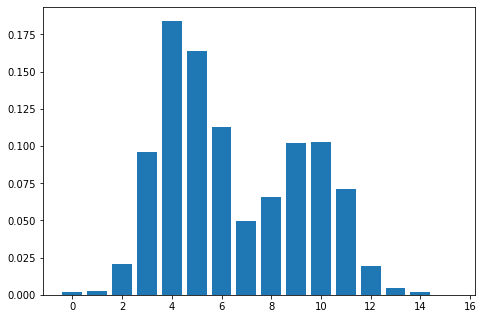

Time for epoch 126 is 9.483532667160034 sec


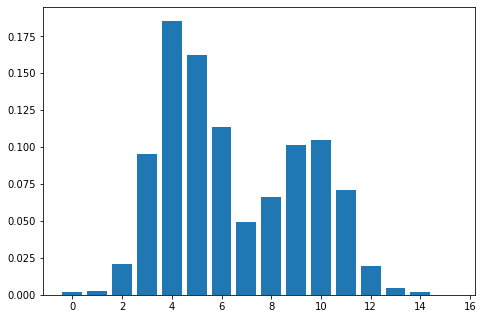

Time for epoch 127 is 9.381273746490479 sec


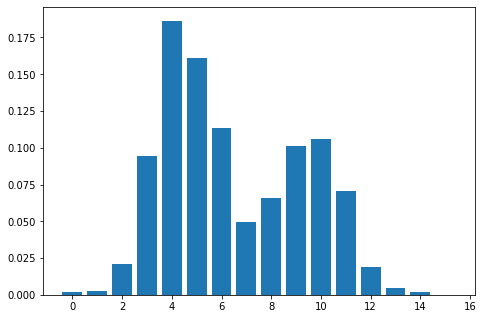

Time for epoch 128 is 9.362998008728027 sec


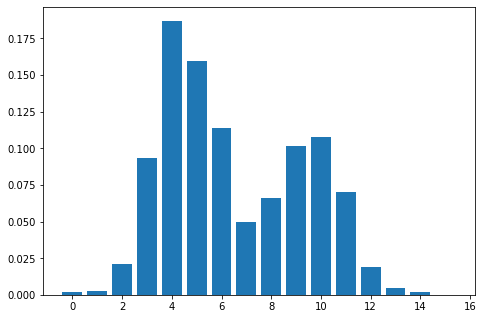

Time for epoch 129 is 9.357329607009888 sec


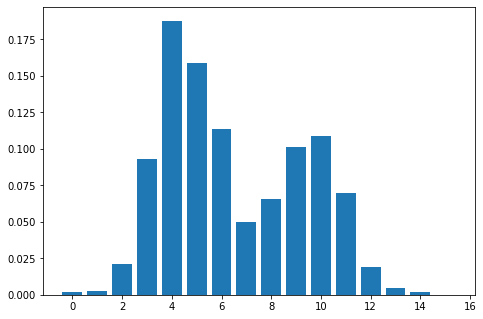

Time for epoch 130 is 9.309659719467163 sec


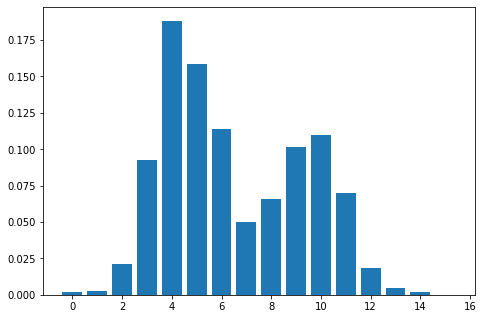

Time for epoch 131 is 9.209048748016357 sec


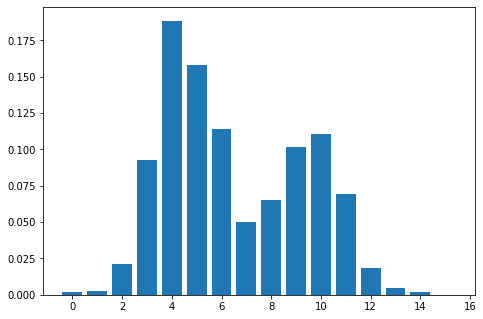

Time for epoch 132 is 9.165226459503174 sec


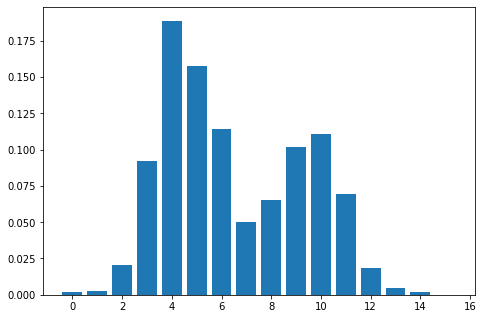

Time for epoch 133 is 9.206183195114136 sec


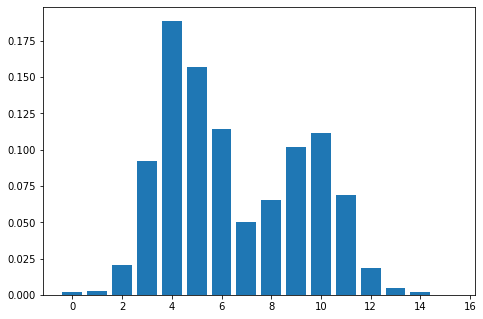

Time for epoch 134 is 9.453525066375732 sec


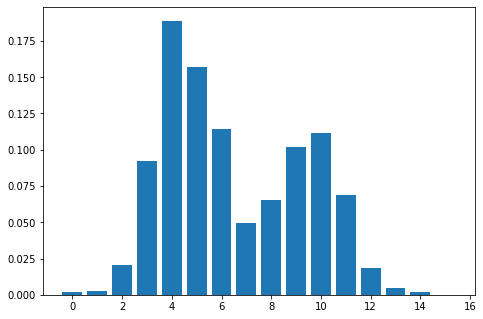

Time for epoch 135 is 9.383023977279663 sec


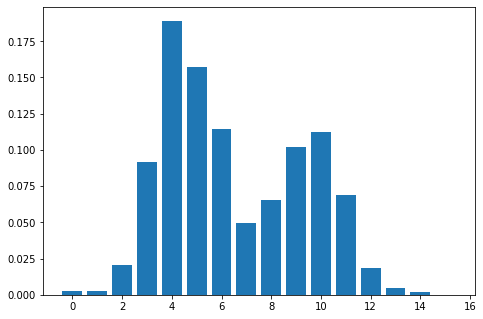

Time for epoch 136 is 9.447986125946045 sec


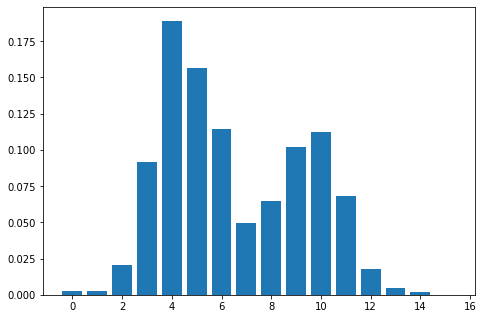

Time for epoch 137 is 9.484140396118164 sec


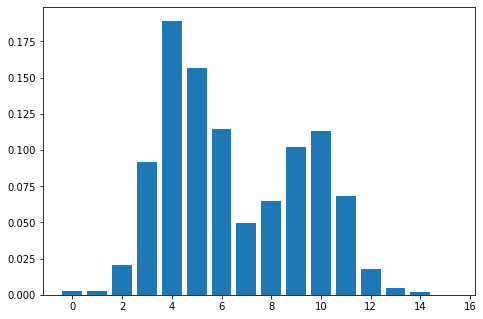

Time for epoch 138 is 9.641996383666992 sec


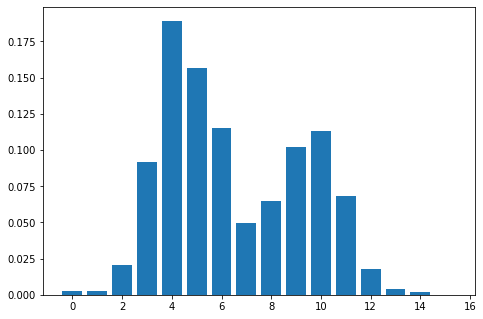

Time for epoch 139 is 9.590457439422607 sec


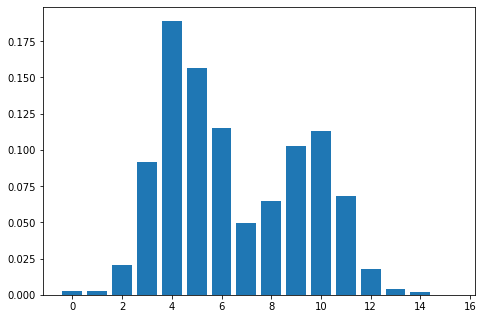

Time for epoch 140 is 9.304215669631958 sec


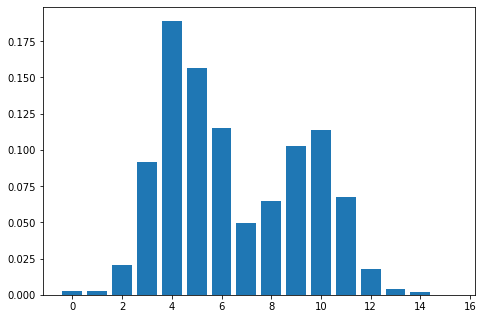

Time for epoch 141 is 9.508304595947266 sec


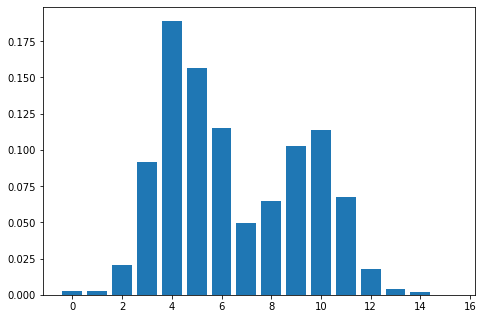

Time for epoch 142 is 9.30422043800354 sec


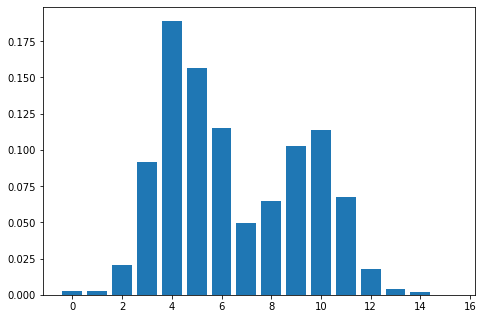

Time for epoch 143 is 9.480276346206665 sec


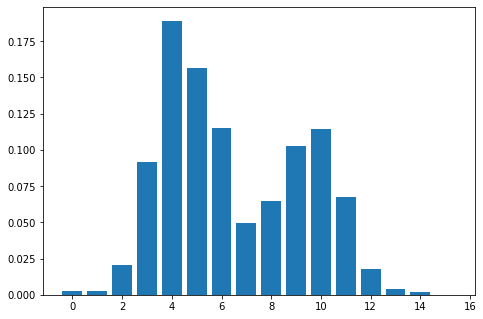

Time for epoch 144 is 10.10404658317566 sec


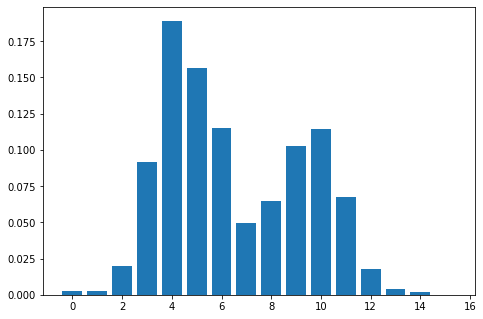

Time for epoch 145 is 9.31997013092041 sec


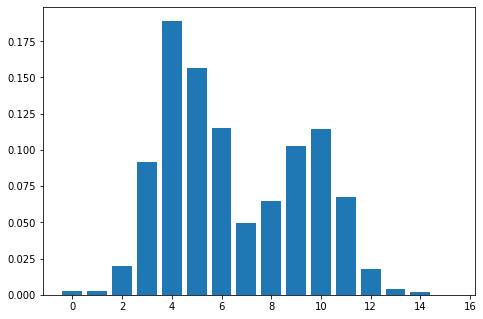

Time for epoch 146 is 10.144733190536499 sec


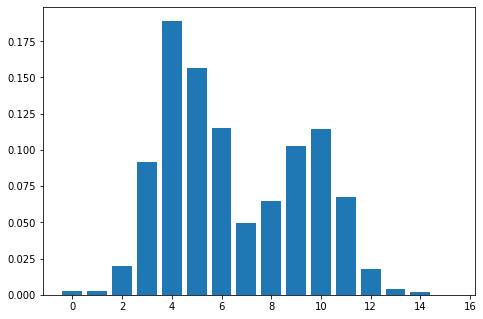

Time for epoch 147 is 9.741627931594849 sec


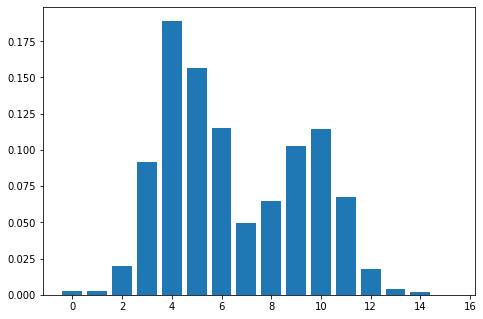

Time for epoch 148 is 9.724546909332275 sec


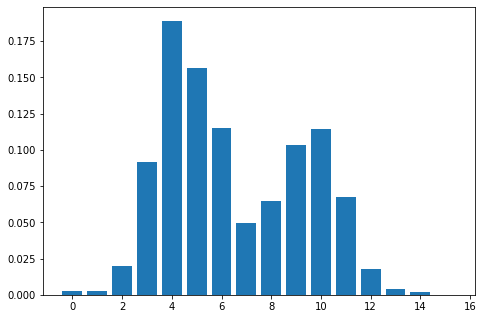

Time for epoch 149 is 9.874599933624268 sec


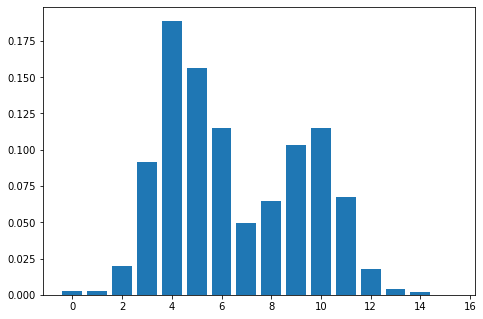

Time for epoch 150 is 9.727680444717407 sec


In [26]:
train(data_loader, EPOCHS)

In [27]:
noise = tf.random.normal([1, 4])
generated_data = generator(noise, training=False).numpy()
generated_data

array([[2.32166614e-03, 2.70579717e-03, 2.00693083e-02, 9.15493720e-02,
        1.89054425e-01, 1.56417394e-01, 1.15099037e-01, 4.92667182e-02,
        6.45673786e-02, 1.03148451e-01, 1.14790559e-01, 6.74376305e-02,
        1.75124295e-02, 4.25851412e-03, 1.76874443e-03, 3.25746460e-05]])

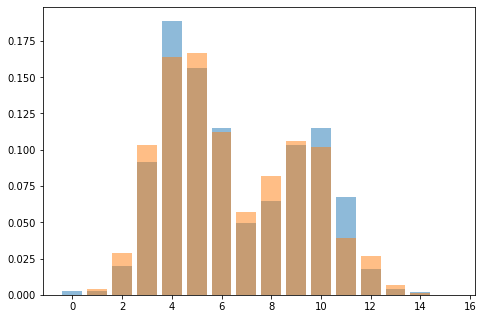

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = range(16)
ax.bar(y, generated_data[0], alpha=0.5)
ax.bar(y, new_point, alpha=0.5)
plt.show()

In [29]:
generator.weights

[<tf.Variable 'sequential/keras_layer/weights:0' shape=(32,) dtype=float32, numpy=
 array([-0.13814904, -0.31910416, -0.09205376,  0.09033211,  0.25331518,
        -0.40732577,  0.2548246 ,  0.40449664, -0.4919371 ,  0.05569111,
        -0.2975443 ,  0.633     , -0.47998402,  0.74405813, -0.31343174,
        -0.7081799 , -0.14245723, -0.1866859 ,  0.46325824,  0.25285488,
         1.5086406 , -0.00726145, -0.07253565,  0.91501606, -0.43337712,
        -0.7036812 ,  0.9834415 , -0.5267657 ,  0.42405945,  0.04205325,
         0.07511523, -0.29565173], dtype=float32)>]